In [1]:
import os, tensorflow, keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Dropout, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import he_normal

In [2]:
# load the dataset => training, cross-validation and test sets

train_dir = os.path.join("/kaggle/input/isic-2017-dataset/content/Linear_Exact_Aug/Train")
test_dir = os.path.join("/kaggle/input/isic-2017-dataset/content/Linear_Exact_Aug/Test")
valid_dir = os.path.join("/kaggle/input/isic-2017-dataset/content/Linear_Exact_Aug/Valid")

# print("Train Directory:", train_dir)
# print("Test Directory:", test_dir)
# print("Validation Directory:", valid_dir)

IMG_SIZE = (400, 400)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 14018 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## minpooling layer

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, MaxPooling2D, Input, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Multiply, Reshape, Dense, Add

def minpooling_layer(input_tensor):
    x = Lambda(lambda z: -z)(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    x = Lambda(lambda z: -z)(x)
    return x

# cbam attention layer

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, MaxPooling2D, Input, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Multiply, Reshape, Dense, Add

def cbam_attention(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', use_bias=True)
    shared_layer_two = Dense(channel, use_bias=True)
    
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = tf.keras.activations.sigmoid(cbam_feature)
    cbam_feature = Multiply()([input_tensor, cbam_feature])
    
    return cbam_feature

# Squeeze and Excitation Attention

In [5]:
def se_block(input_tensor, reduction = 16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // reduction, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    
    return Multiply()([input_tensor, se])

# CNN Model (DenseNet architecture)

In [6]:
def build_model():
    input_layer = Input(shape=(400, 400, 3))
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_layer)

    # Apply CBAM attention
    # x = base_model.output
    # x = cbam_attention(x)

    # Apply Squeeze and Excitation Attention
    x = base_model.output
    x = se_block(x)

    # Apply Minpooling
    x = minpooling_layer(x)
    x = minpooling_layer(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(negative_slope=0.02)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU(negative_slope=0.02)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    # Output Layer
    output_layer = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)

    return Model(inputs=input_layer, outputs=output_layer)

# building model

In [7]:
denseNetLeakyV2Model = build_model()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Model Summary

In [8]:
denseNetLeakyV2Model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 400, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 406, 406, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 200, 200, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 200, 200, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 200, 200, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 202, 202, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 100, 64)   │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 100, 100, 64)   │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 100, 100, 128)  │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 100, 100, 128)  │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 100, 100, 128)  │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 100, 100, 32)   │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 100, 100, 96)   │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 19,286,075 (73.57 MB)

 Trainable params: 19,056,443 (72.69 MB)

 Non-trainable params: 229,632 (897.00 KB)

# Model compilation

In [9]:
# compiling the model
denseNetLeakyV2Model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler: Reduce LR if validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# setting checkpoint for the optimal weights corresponding to the minimum loss
checkpoint = ModelCheckpoint("/kaggle/working/denseNetLeakyV2Model.weights.h5", monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)

# Early Stopping: Stop training if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Model fitting

In [10]:
# fitting the model
history = denseNetLeakyV2Model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 70,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5502 - loss: 1.6517
Epoch 1: val_loss improved from inf to 1.41066, saving model to /kaggle/working/denseNetLeakyV2Model.weights.h5
439/439 ━━━━━━━━━━━━━━━━━━━━ 1127s 2s/step - accuracy: 0.5504 - loss: 1.6511 - val_accuracy: 0.5467 - val_loss: 1.4107 - learning_rate: 1.0000e-04
Epoch 2/70
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.7885 - loss: 0.8978
Epoch 2: val_loss improved from 1.41066 to 1.23528, saving model to /kaggle/working/denseNetLeakyV2Model.weights.h5
439/439 ━━━━━━━━━━━━━━━━━━━━ 369s 838ms/step - accuracy: 0.7885 - loss: 0.8978 - val_accuracy: 0.6933 - val_loss: 1.2353 - learning_rate: 1.0000e-04
Epoch 3/70
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.8457 - loss: 0.7235
Epoch 3: val_loss improved from 1.23528 to 0.82097, saving model to /kaggle/working/denseNetLeakyV2Model.weights.h5
439/439 ━━━━━━━━━━━━━━━━━━━━ 370s 839ms/step - accuracy: 0.8457 - loss: 0.7235 - val_accuracy: 0.8267 - val_lo

# Loading optimized weights

In [11]:
# Load and display the optimized weights

# Load best weights
denseNetLeakyV2Model.save_weights("/kaggle/working/denseNetLeakyV2Model.weights.h5")

# Get all layer weights as a list of NumPy arrays
optimized_weights = denseNetLeakyV2Model.get_weights()

# Print weight values for each layer
'''for i, weight in enumerate(optimized_weights):
    print(f"Weight {i+1}: Shape = {weight.shape}")
    print(weight)
    print("\n" + "-"*50)***
'''

'for i, weight in enumerate(optimized_weights):\n    print(f"Weight {i+1}: Shape = {weight.shape}")\n    print(weight)\n    print("\n" + "-"*50)***\n'

# Validation dataset accuracy

In [23]:
# validation loss and validation accurracy
from sklearn.metrics import accuracy_score
import numpy as np

class_map = {0: "melanoma", 1: "nevus", 2:"seborrheic-keratosis"}

# Model evaluation
validation_loss, validation_accuracy = denseNetLeakyV2Model.evaluate(valid_generator)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation loss: {validation_loss:.4f}")


# Model predictions
valid_generator.shuffle = True
predictions_valid = denseNetLeakyV2Model.predict(valid_generator)
predicted_classes_valid = np.argmax(predictions_valid, axis=1)
true_classes = valid_generator.classes
test_length = len(true_classes)

# Print predicted classes on validation set
# print("Predicted vs True Classes:")
# for i in range(test_length):
    # print(f"Sample {i+1:<3}: Predicted = {class_map[predicted_classes[i]]:<25} True = {class_map[true_classes[i]]:<25}")

# individual percentage of correctly predicted classes
mel, nev, seb = 0, 0, 0
for i in range(test_length):
    mel += (true_classes[i] == 0)
    nev += (true_classes[i] == 1)
    seb += (true_classes[i] == 2)

print(mel, nev, seb)

correct_mel, correct_nev, correct_seb = 0, 0, 0

for i in range(mel):
    correct_mel += (predicted_classes_valid[i] == 0)

for i in range(mel, mel+nev):
    correct_nev += (predicted_classes_valid[i] == 1)

for i in range(mel+nev, test_length):
    correct_seb += (predicted_classes_valid[i] == 2)

print("Correctly predicted melanoma: ", (correct_mel / mel) * 100, "%")
print("Correctly predicted nevus: ", (correct_nev / nev) * 100, "%")
print("Correctly predicted seborrheic-keratosis: ", (correct_seb / seb) * 100, "%")


# Computing correct prediction percentage
accuracy = accuracy_score(true_classes, predicted_classes_valid) * 100
print(f"Correct Prediction Percentage: {accuracy:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.7548 - loss: 0.9834
Validation Accuracy: 84.00%
Validation loss: 0.7149
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
30 78 42
Correctly predicted melanoma:  46.666666666666664 %
Correctly predicted nevus:  94.87179487179486 %
Correctly predicted seborrheic-keratosis:  90.47619047619048 %
Correct Prediction Percentage: 84.00%


# test dataset accuracy

In [21]:
# test loss and test accurracy
from sklearn.metrics import accuracy_score
import numpy as np

class_map = {0: "melanoma", 1: "nevus", 2:"seborrheic-keratosis"}

# Model evaluation
test_loss, test_accuracy = denseNetLeakyV2Model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")


# Model predictions
test_generator.shuffle = True
predictions_test = denseNetLeakyV2Model.predict(test_generator)
predicted_classes_test = np.argmax(predictions_test, axis=1)
true_classes = test_generator.classes
test_length = len(true_classes)

# Print predicted classes on the test dataset
# print("Predicted vs True Classes:")
# for i in range(test_length):
    # print(f"Sample {i+1:<3}: Predicted = {class_map[predicted_classes[i]]:<25} True = {class_map[true_classes[i]]:<25}")

# individual percentage of correctly predicted classes
mel, nev, seb = 0, 0, 0
for i in range(test_length):
    mel += (true_classes[i] == 0)
    nev += (true_classes[i] == 1)
    seb += (true_classes[i] == 2)

print(mel, nev, seb)

correct_mel, correct_nev, correct_seb = 0, 0, 0

for i in range(mel):
    correct_mel += (predicted_classes_test[i] == 0)

for i in range(mel, mel+nev):
    correct_nev += (predicted_classes_test[i] == 1)

for i in range(mel+nev, test_length):
    correct_seb += (predicted_classes_test[i] == 2)

print("Correctly predicted melanoma: ", (correct_mel / mel) * 100, "%")
print("Correctly predicted nevus: ", (correct_nev / nev) * 100, "%")
print("Correctly predicted seborrheic-keratosis: ", (correct_seb / seb) * 100, "%")


# Computing correct prediction percentage
accuracy = accuracy_score(true_classes, predicted_classes_test) * 100
print(f"Correct Prediction Percentage: {accuracy:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.7335 - loss: 1.1871
Test Accuracy: 81.17%
Test loss: 0.8368
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step
117 393 90
Correctly predicted melanoma:  58.119658119658126 %
Correctly predicted nevus:  88.29516539440203 %
Correctly predicted seborrheic-keratosis:  80.0 %
Correct Prediction Percentage: 81.17%


# Scatterplot with classifier

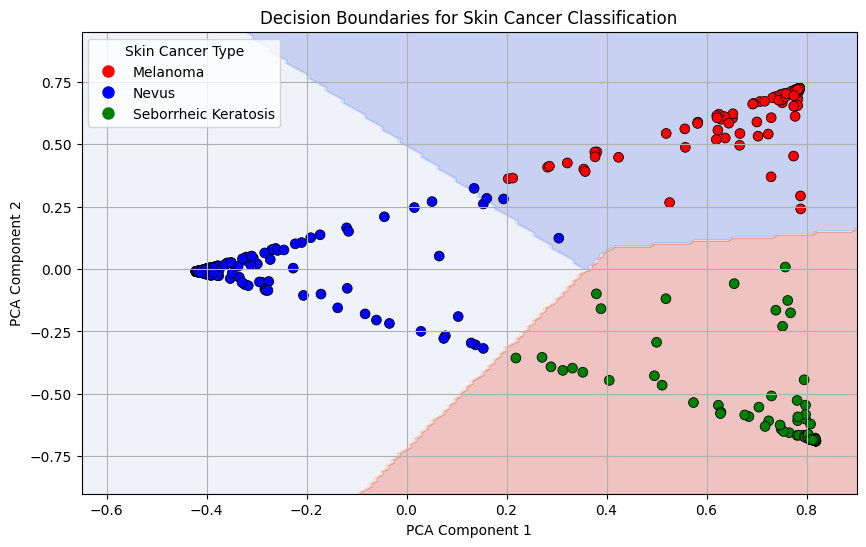

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # Using SVM for decision boundaries

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
test_data_2d = pca.fit_transform(predictions_test)

# Train a classifier (SVM) on the PCA-transformed data
svm_model = SVC(kernel="linear", C=1.0)  # Linear SVM for decision boundaries
svm_model.fit(test_data_2d, predicted_classes_test)

# Create a mesh grid for shading the decision regions
x_min, x_max = test_data_2d[:, 0].min() - 0.5, test_data_2d[:, 0].max() + 0.5
y_min, y_max = test_data_2d[:, 1].min() - 0.5, test_data_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict class for each point in the mesh grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define color mappings
colors = ['red', 'blue', 'green']
class_names = ['Melanoma', 'Nevus', 'Seborrheic Keratosis']
region_colors = ["red", "blue", "green"]

# Plot decision boundary with shading
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Scatter plot with actual test points
sns.scatterplot(x=test_data_2d[:, 0], y=test_data_2d[:, 1], hue=predicted_classes_test, palette=colors, edgecolor='k', s=50)

# Improve visualization
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundaries for Skin Cancer Classification")
plt.legend(handles=[plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[i], markersize=10, label=class_names[i]) for i in range(3)], title="Skin Cancer Type", loc="upper left")
plt.xlim(-0.65, 0.9)  
plt.ylim(-0.9, 0.95)   


plt.grid(True)
plt.show()

# Training vs validation accuracy

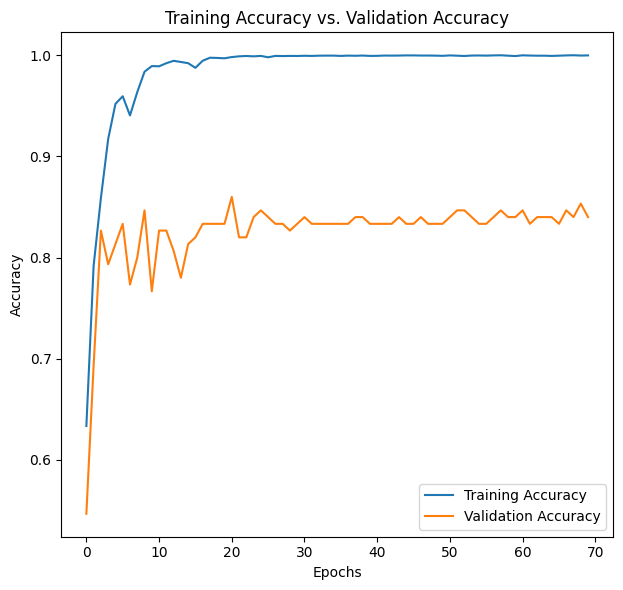

In [26]:
# Get accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training Accuracy vs. Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', linestyle='-')
plt.plot(val_accuracy, label='Validation Accuracy', linestyle='-')
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Training vs validation loss

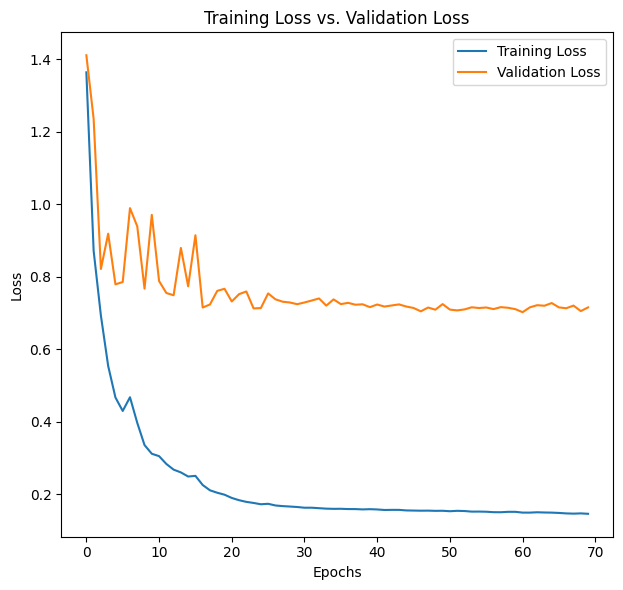

In [27]:
# Get accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training Loss vs. Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', linestyle='-')
plt.plot(val_loss, label='Validation Loss', linestyle='-')
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Confusion Matrix

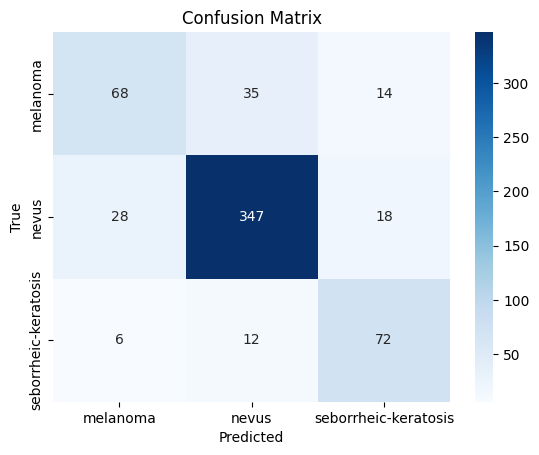

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes_test)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=class_map.values(), yticklabels=class_map.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall and F1 Score

In [37]:
from sklearn.metrics import classification_report
import numpy as np

# Generate classification report
true_classes = test_generator.classes
report = classification_report(true_classes, predicted_classes_test, target_names=test_generator.class_indices.keys())
print("CLASSIFICATION REPORT\n")
print(report)

CLASSIFICATION REPORT

                      precision    recall  f1-score   support

            melanoma       0.67      0.58      0.62       117
               nevus       0.88      0.88      0.88       393
seborrheic_keratosis       0.69      0.80      0.74        90

            accuracy                           0.81       600
           macro avg       0.75      0.75      0.75       600
        weighted avg       0.81      0.81      0.81       600

